In [2]:
from Controller import TrainingController, ExplainingController
from Utils.SaveUtils import load_parameters
from Parameters import TrainingParameters, PredictingParameters
import tensorflow as tf
from IPython.core.display import display, HTML
import json
import numpy as np
import pandas as pd
from Parameters.Enums import TracePermutationStrategies
from Utils import VocabDict
from typing import List
from enum import Enum
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

In [3]:
### Select models to load
folder_path = "./SavedModels/%s" % (
 "0.7924_BPI2012_BaseLineLSTMModel_2021-06-11 17:08:27.383137" # AOW
)

In [4]:
### Setting up parameters
parameters_json = load_parameters(folder_path=folder_path)
parameters = TrainingParameters(**parameters_json)
tf.random.set_seed(parameters.dataset_split_seed)
np.random.seed(parameters.dataset_split_seed)
parameters.load_model_folder_path = folder_path
predicting_parameters = PredictingParameters()
predicting_parameters.load_model_folder_path = folder_path

In [5]:
trainer = TrainingController(parameters = parameters)


| Running on /job:localhost/replica:0/task:0/device:CPU:0  

| Preprocessed data loaded successfully: ./datasets/preprocessed/BPI_Challenge_2012/AOW 

| Model loaded successfully from: ./SavedModels/0.7924_BPI2012_BaseLineLSTMModel_2021-06-11 17:08:27.383137  


In [6]:
print("========================All Vocabs========================")
trainer.model.vocab.vocabs

========================All Vocabs========================


['<PAD>',
 '<EOS>',
 '<SOS>',
 'A_ACCEPTED_COMPLETE',
 'A_ACTIVATED_COMPLETE',
 'A_APPROVED_COMPLETE',
 'A_CANCELLED_COMPLETE',
 'A_DECLINED_COMPLETE',
 'A_FINALIZED_COMPLETE',
 'A_PARTLYSUBMITTED_COMPLETE',
 'A_PREACCEPTED_COMPLETE',
 'A_REGISTERED_COMPLETE',
 'A_SUBMITTED_COMPLETE',
 'O_ACCEPTED_COMPLETE',
 'O_CANCELLED_COMPLETE',
 'O_CREATED_COMPLETE',
 'O_DECLINED_COMPLETE',
 'O_SELECTED_COMPLETE',
 'O_SENT_BACK_COMPLETE',
 'O_SENT_COMPLETE',
 'W_Afhandelen leads_COMPLETE',
 'W_Beoordelen fraude_COMPLETE',
 'W_Completeren aanvraag_COMPLETE',
 'W_Nabellen incomplete dossiers_COMPLETE',
 'W_Nabellen offertes_COMPLETE',
 'W_Valideren aanvraag_COMPLETE']

In [7]:
### Identified important activities
a_important_activities = ["A_ACTIVATED_COMPLETE", "A_APPROVED_COMPLETE", "A_REGISTERED_COMPLETE", "A_DECLINED_COMPLETE"]
o_important_activities = ["O_ACCEPTED_COMPLETE", "O_DECLINED_COMPLETE"]
all_important_vocabs = a_important_activities + o_important_activities
print("===============Important Activities===============")
print(all_important_vocabs)

===============Important Activities===============
['A_ACTIVATED_COMPLETE', 'A_APPROVED_COMPLETE', 'A_REGISTERED_COMPLETE', 'A_DECLINED_COMPLETE', 'O_ACCEPTED_COMPLETE', 'O_DECLINED_COMPLETE']


In [8]:
########### What's the ending activities and their occurence counts ###########
all_last_steps =  [i[-2] for i in trainer.dataset.df["trace"]]
last_df = pd.DataFrame(all_last_steps, columns=["last_step"])
ending_vocab_counts = {}
ending_value_count_dict = dict(last_df["last_step"].value_counts())
for k in ending_value_count_dict:
    vocab_key = trainer.model.vocab.index_to_vocab(k)
    ending_vocab_counts[vocab_key] = ending_value_count_dict[k]

print(ending_vocab_counts)

{'A_DECLINED_COMPLETE': 3429, 'W_Valideren aanvraag_COMPLETE': 2749, 'W_Afhandelen leads_COMPLETE': 2234, 'W_Completeren aanvraag_COMPLETE': 1939, 'W_Nabellen offertes_COMPLETE': 1291, 'A_CANCELLED_COMPLETE': 655, 'W_Nabellen incomplete dossiers_COMPLETE': 453, 'O_CANCELLED_COMPLETE': 279, 'W_Beoordelen fraude_COMPLETE': 57, 'A_REGISTERED_COMPLETE': 1}


In [9]:
print("Most common ending activities: ")
print(trainer.model.vocab.list_of_index_to_vocab(list(last_df["last_step"].value_counts().keys())))

Most common ending activities: 
['A_DECLINED_COMPLETE', 'W_Valideren aanvraag_COMPLETE', 'W_Afhandelen leads_COMPLETE', 'W_Completeren aanvraag_COMPLETE', 'W_Nabellen offertes_COMPLETE', 'A_CANCELLED_COMPLETE', 'W_Nabellen incomplete dossiers_COMPLETE', 'O_CANCELLED_COMPLETE', 'W_Beoordelen fraude_COMPLETE', 'A_REGISTERED_COMPLETE']


In [10]:
########### Get example data from trainer ###########
trainer.test_dataset.unbatch()
ordered_test_idx = (list(trainer.test_dataset.unbatch().as_numpy_iterator()))
ordered_test_idx.sort()
print("Test set size: %d" %(len(ordered_test_idx)))
success_activities = ['O_ACCEPTED_COMPLETE', 'A_APPROVED_COMPLETE', 'A_REGISTERED_COMPLETE']
all_success_case_in_test = []
for i in ordered_test_idx:
    idx_trace = trainer.dataset.collate_fn([i])[1][0]
    vocab_trace = trainer.model.vocab.list_of_index_to_vocab(idx_trace.tolist())
    if any([ s_a in vocab_trace  for s_a in success_activities]):
        all_success_case_in_test.append(i)

all_fail_case_in_test = [ i for i in ordered_test_idx if (i not in all_success_case_in_test) ]
print("Trace count (Successful): %d " % (len(all_success_case_in_test))) 
print("Trace count (Failed): %d " % (len(all_fail_case_in_test))) 

Test set size: 1308
Trace count (Successful): 224 
Trace count (Failed): 1084 


In [11]:
mean_success_length = np.mean([len(trainer.dataset.collate_fn([i])[1][0]) for i in all_success_case_in_test])
mean_fail_length = np.mean([len(trainer.dataset.collate_fn([i])[1][0]) for i in all_fail_case_in_test])
print("Mean trace length (Successful): %.2f " % (mean_success_length)) 
print("Mean trace length (Failed): %.2f " % (mean_fail_length)) 

Mean trace length (Successful): 27.94 
Mean trace length (Failed): 10.53 


In [12]:
success_case_idx = 2
fail_case_idx = 20
print("=========================Accepted=========================")
accpeted_example_idx_trace = trainer.dataset.collate_fn([all_success_case_in_test[success_case_idx]])[1][0]
accpeted_example_vocab_trace = trainer.model.vocab.list_of_index_to_vocab(accpeted_example_idx_trace.tolist())
print(accpeted_example_vocab_trace)
print("=========================Failed===========================")
failed_example_idx_trace = trainer.dataset.collate_fn([all_fail_case_in_test[fail_case_idx]])[1][0]
failed_example_vocab_trace = trainer.model.vocab.list_of_index_to_vocab(failed_example_idx_trace.tolist())
print(failed_example_vocab_trace)

=========================Accepted=========================
['<SOS>', 'A_SUBMITTED_COMPLETE', 'A_PARTLYSUBMITTED_COMPLETE', 'A_PREACCEPTED_COMPLETE', 'A_ACCEPTED_COMPLETE', 'O_SELECTED_COMPLETE', 'A_FINALIZED_COMPLETE', 'O_CREATED_COMPLETE', 'O_SENT_COMPLETE', 'W_Completeren aanvraag_COMPLETE', 'W_Nabellen offertes_COMPLETE', 'W_Nabellen offertes_COMPLETE', 'W_Nabellen offertes_COMPLETE', 'W_Nabellen offertes_COMPLETE', 'W_Nabellen offertes_COMPLETE', 'W_Nabellen offertes_COMPLETE', 'W_Nabellen offertes_COMPLETE', 'W_Nabellen offertes_COMPLETE', 'W_Nabellen offertes_COMPLETE', 'W_Nabellen offertes_COMPLETE', 'O_SENT_BACK_COMPLETE', 'W_Nabellen offertes_COMPLETE', 'A_APPROVED_COMPLETE', 'O_ACCEPTED_COMPLETE', 'A_REGISTERED_COMPLETE', 'A_ACTIVATED_COMPLETE', 'W_Valideren aanvraag_COMPLETE']
=========================Failed===========================
['<SOS>', 'A_SUBMITTED_COMPLETE', 'A_PARTLYSUBMITTED_COMPLETE', 'A_PREACCEPTED_COMPLETE', 'A_ACCEPTED_COMPLETE', 'O_SELECTED_COMPLETE', 'A_FIN

# Milestones analysis

In [12]:
class CaseClassifier:
    def __init__(self, vocab: VocabDict, success_vocab, cancel_vocab, decline_vocab):
        self.vocab = vocab
        self.success_vocab = success_vocab
        self.success_idx = self.vocab.vocab_to_index(self.success_vocab)
        self.cancel_vocab = cancel_vocab
        self.cancel_idx = self.vocab.vocab_to_index(self.cancel_vocab)
        self.decline_vocab = decline_vocab
        self.decline_idx = self.vocab.vocab_to_index(self.decline_vocab)
    def isSuccessCase_idx(self, idx_trace: List[int]):
        return self.success_idx in idx_trace

    def isCancelCase_idx(self, idx_trace: List[int]):
        return self.cancel_idx in idx_trace

    def isDeclineCase_idx(self, idx_trace: List[int]):
        return self.decline_idx in idx_trace

    def isSuccessCase_vocabs(self, vocabs_trace: List[str]):
        return self.isSuccessCase_idx(self.vocab.list_of_vocab_to_index(vocabs_trace))
        
    def isCancelCase_vocabs(self, vocabs_trace: List[str]):
        return self.isCancelCase_idx(self.vocab.list_of_vocab_to_index(vocabs_trace))           
    def isDeclineCase_vocabs(self,vocabs_trace: List[str]):
        return self.isDeclineCase_idx(self.vocab.list_of_vocab_to_index(vocabs_trace))
    
    def get_case_type_idx(self, idx_trace: List[int]):
        trace_types = []
        if (self.isSuccessCase_idx(idx_trace)):
            trace_types.append("Success")

        if (self.isCancelCase_idx(idx_trace)):
            trace_types.append("Cancel")

        if (self.isDeclineCase_idx(idx_trace)):
            trace_types.append("Decline")
        
        return trace_types

    def get_case_status_idx(self, idx_trace: List[int]):
        if (self.isSuccessCase_idx(idx_trace)):
            return "Success"

        if (self.isCancelCase_idx(idx_trace)):
            return "Cancel"

        if (self.isDeclineCase_idx(idx_trace)):
            return "Decline"

        return "Incomplete"

    def get_case_type_vocabs(self, vocabs_trace: List[int]):
         return get_case_type_idx(self.vocab.list_of_vocab_to_index(vocabs_trace))

In [13]:
cclf = CaseClassifier(
    vocab=trainer.dataset.vocab,                    
    success_vocab="A_APPROVED_COMPLETE",
    cancel_vocab = "A_CANCELLED_COMPLETE",
    decline_vocab = "A_DECLINED_COMPLETE"
    )

In [14]:
case_df = trainer.dataset.df
case_types = [ cclf.get_case_status_idx(t)  for t in list(case_df["trace"])]
case_df["case_types"] = case_types

In [15]:
case_df["case_types"].value_counts()

Decline       7635
Cancel        2807
Success       2246
Incomplete     399
Name: case_types, dtype: int64

In [16]:
## Remove incomplete path that we don't need to analyse 
case_df = case_df[case_df["case_types"] != "Incomplete"]

In [17]:
### Checking if the trace has certain activity
for v in trainer.model.vocab.vocabs:
    case_df["has_%s" % (v)]  = [trainer.model.vocab.vocab_to_index(v) in t for t in case_df["trace"]]

<ipython-input-17-bd4082fdcc66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case_df["has_%s" % (v)]  = [trainer.model.vocab.vocab_to_index(v) in t for t in case_df["trace"]]


## Three milestones to consider
```
milestones = ["A_PREACCEPTED_COMPLETE", "A_ACCEPTED_COMPLETE", "A_FINALIZED_COMPLETE"]
```

![](https://trello-attachments.s3.amazonaws.com/60a5e9e5cea3fa814b2f498a/60c359bf7362486526af0c1c/4fb9b62b68dd8e8176abb25e6a4a356d/IMG_0374_copy.jpg)

## Count checking

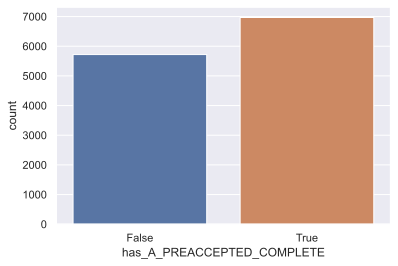

In [18]:
ax = sns.countplot(x="has_A_PREACCEPTED_COMPLETE",  data=case_df)

Text(0.5, 1.0, 'Trace has "A_PREACCEPTED_COMPLETE"')

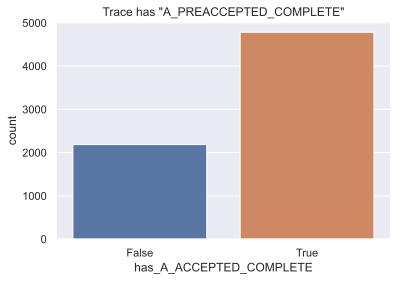

In [19]:
sns.countplot(x="has_A_ACCEPTED_COMPLETE", data = case_df[case_df["has_A_PREACCEPTED_COMPLETE"]]).set_title("Trace has \"A_PREACCEPTED_COMPLETE\"")

Text(0.5, 1.0, 'Trace has "A_PREACCEPTED_COMPLETE" and "A_ACCEPTED_COMPLETE"')

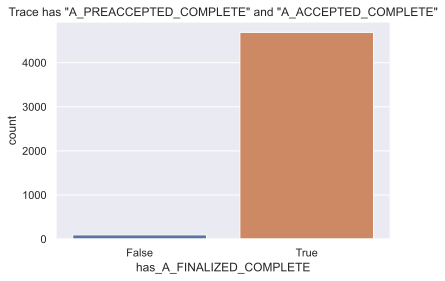

In [20]:
sns.countplot(x="has_A_FINALIZED_COMPLETE", data = case_df[[ a and b for a,b in zip(case_df["has_A_PREACCEPTED_COMPLETE"], case_df["has_A_ACCEPTED_COMPLETE"])]]).set_title("Trace has \"A_PREACCEPTED_COMPLETE\" and \"A_ACCEPTED_COMPLETE\"")

## Success, Cancel, Decline checking

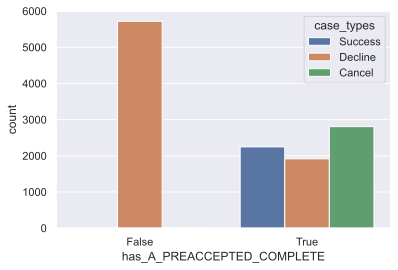

In [21]:
ax = sns.countplot(x="has_A_PREACCEPTED_COMPLETE", hue="case_types", data=case_df)

Text(0.5, 1.0, 'Trace has "A_PREACCEPTED_COMPLETE"')

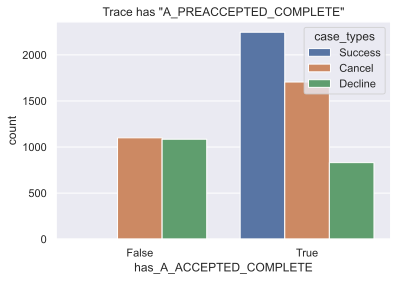

In [22]:
sns.countplot(x="has_A_ACCEPTED_COMPLETE",hue="case_types", data = case_df[case_df["has_A_PREACCEPTED_COMPLETE"]==True]).set_title("Trace has \"A_PREACCEPTED_COMPLETE\"")

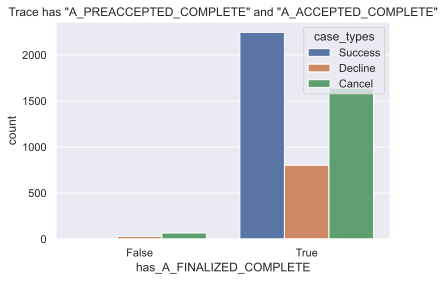

In [23]:
ax = sns.countplot(x="has_A_FINALIZED_COMPLETE", hue="case_types", data = case_df[[ a and b for a,b in zip(case_df["has_A_PREACCEPTED_COMPLETE"], case_df["has_A_ACCEPTED_COMPLETE"])]]).set_title("Trace has \"A_PREACCEPTED_COMPLETE\" and \"A_ACCEPTED_COMPLETE\"")

## Trace length

In [24]:
### Calculate the length of them.
case_df['len_trace'] =[ len(t) for t in case_df["trace"]]

<ipython-input-24-765f08db8da5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  case_df['len_trace'] =[ len(t) for t in case_df["trace"]]


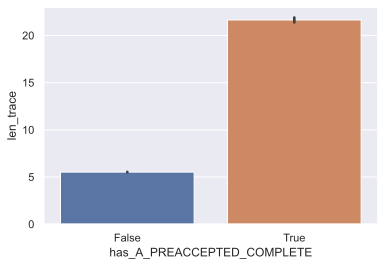

In [25]:
ax = sns.barplot(x="has_A_PREACCEPTED_COMPLETE", y="len_trace", data = case_df)

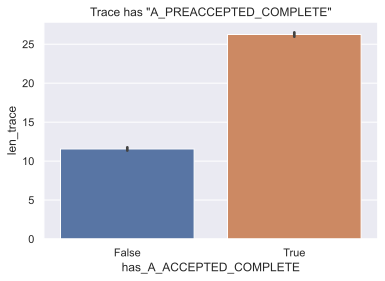

In [26]:
ax = sns.barplot(x="has_A_ACCEPTED_COMPLETE", y="len_trace", data = case_df[case_df["has_A_PREACCEPTED_COMPLETE"]]).set_title("Trace has \"A_PREACCEPTED_COMPLETE\"")

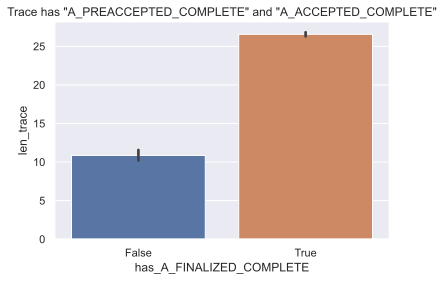

In [27]:
ax = sns.barplot(x="has_A_FINALIZED_COMPLETE", y="len_trace", data = case_df[[ a and b for a,b in zip(case_df["has_A_PREACCEPTED_COMPLETE"], case_df["has_A_ACCEPTED_COMPLETE"])]]).set_title("Trace has \"A_PREACCEPTED_COMPLETE\" and \"A_ACCEPTED_COMPLETE\"")

##  Vocab / outcome.

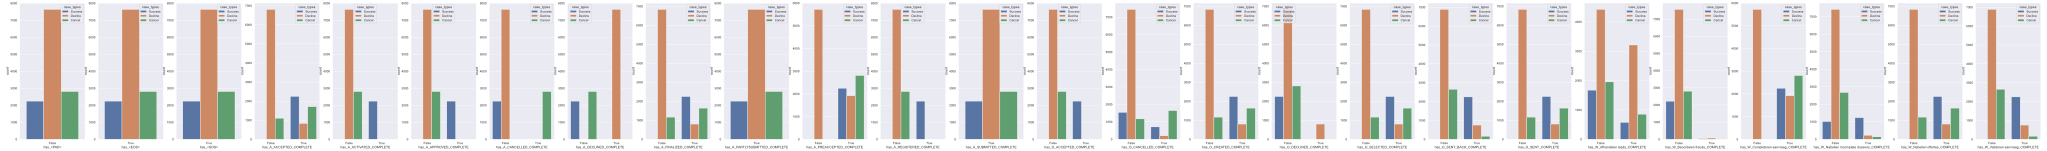

In [28]:
# Has O_Cancelled is interesting.
fig, axes = plt.subplots(1,len(trainer.model.vocab), figsize=(len(trainer.model.vocab)*5, 9), dpi=200)
for i, v in enumerate(trainer.model.vocab.vocabs):
    sns.countplot(ax=axes[i], data=case_df, x="has_%s" % (v), hue="case_types")

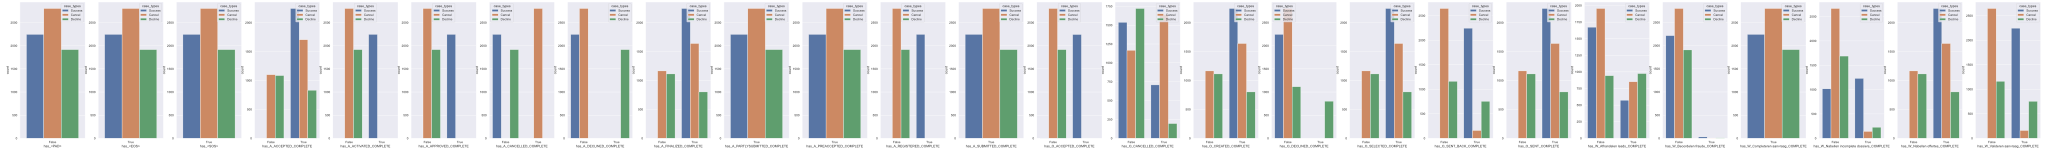

In [29]:
fig, axes = plt.subplots(1,len(trainer.model.vocab), figsize=(len(trainer.model.vocab)*5, 9), dpi=200)
for i, v in enumerate(trainer.model.vocab.vocabs):
    sns.countplot(ax=axes[i], data= case_df[case_df["has_A_PREACCEPTED_COMPLETE"]], x="has_%s" % (v), hue="case_types")

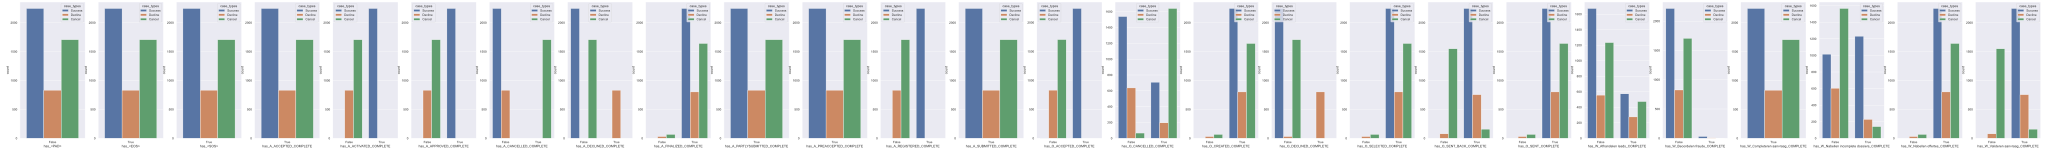

In [30]:
fig, axes = plt.subplots(1,len(trainer.model.vocab), figsize=(len(trainer.model.vocab)*5, 9), dpi=200)
for i, v in enumerate(trainer.model.vocab.vocabs):
    sns.countplot(ax=axes[i], data= case_df[[ a and b for a,b in zip(case_df["has_A_PREACCEPTED_COMPLETE"], case_df["has_A_ACCEPTED_COMPLETE"])]], x="has_%s" % (v), hue="case_types")

# The one doesn't have (O_CANCELLED_COMPLETE & W_AFhandelen leads_COMPLETE) will be easier to reach success state.

In [31]:
### Have "has_O_CANCELLED_COMPLETE" but still success.
[trainer.model.vocab.list_of_index_to_vocab(t)  for t in case_df[[ a and b for a,b in zip(case_df["has_O_CANCELLED_COMPLETE"],case_df["case_types"]=="Success")]]["trace"]][0]

['<SOS>',
 'A_SUBMITTED_COMPLETE',
 'A_PARTLYSUBMITTED_COMPLETE',
 'A_PREACCEPTED_COMPLETE',
 'W_Completeren aanvraag_COMPLETE',
 'A_ACCEPTED_COMPLETE',
 'A_FINALIZED_COMPLETE',
 'O_SELECTED_COMPLETE',
 'O_CREATED_COMPLETE',
 'O_SENT_COMPLETE',
 'W_Completeren aanvraag_COMPLETE',
 'W_Nabellen offertes_COMPLETE',
 'O_CANCELLED_COMPLETE',
 'O_SELECTED_COMPLETE',
 'O_CREATED_COMPLETE',
 'O_SENT_COMPLETE',
 'W_Nabellen offertes_COMPLETE',
 'W_Nabellen offertes_COMPLETE',
 'O_SENT_BACK_COMPLETE',
 'W_Nabellen offertes_COMPLETE',
 'W_Valideren aanvraag_COMPLETE',
 'W_Valideren aanvraag_COMPLETE',
 'O_ACCEPTED_COMPLETE',
 'A_ACTIVATED_COMPLETE',
 'A_APPROVED_COMPLETE',
 'A_REGISTERED_COMPLETE',
 'W_Valideren aanvraag_COMPLETE',
 '<EOS>']